<a href="https://colab.research.google.com/github/Geuens/curso_ai/blob/main/Copy_of_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargamos los datos MNIST

In [ ]:
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 255.0 * 2 - 1  # Normalizar a [-1, 1]
X_train = np.expand_dims(X_train, axis=3)


11490434/11490434 [==============================] - 0s 0us/step


Creamos el generador de imagenes

In [ ]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model


Creamos el discriminador

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model


Creamos la GAN

In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Construir y compilar el discriminador
discriminator = build_discriminator(X_train.shape[1:])
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Construir el generador
generator = build_generator(100)

# Mantener el discriminador no entrenable cuando se entrena la GAN
discriminator.trainable = False

# Construir y compilar la GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


Entranmos la GAN

1/1 [==============================] - 0s 61ms/step


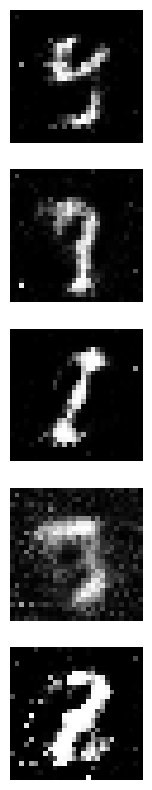

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    for iteration in range(iterations):
        # ----------- Entrenar el Discriminador -----------
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ----------- Entrenar el Generador -----------
        z = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print(f"Iteración {iteration + 1}, [D pérdida: {d_loss}, precisión: {100.0 * accuracy}%], [G pérdida: {g_loss}]")
    discriminator.save('/content/drive/MyDrive/Colab Notebooks/discriminator_gan_mnist.keras')
    generator.save('/content/drive/MyDrive/Colab Notebooks/generator_gan_mnist.keras')

def generate_images(generator, image_count, z_dim):
    z = np.random.normal(0, 1, (image_count, z_dim))
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Escalar las imágenes a [0, 1]

    fig, axs = plt.subplots(image_count, 1, figsize=(10, 10))
    cnt = 0
    for i in range(image_count):
        axs[i].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i].axis('off')
        cnt += 1
    plt.show()

if (os.path.exists('/content/drive/MyDrive/Colab Notebooks/generator_gan_mnist.keras')):
    # Cargar el Generador
    generator = load_model('/content/drive/MyDrive/Colab Notebooks/generator_gan_mnist.keras')
    # Cargar el Discriminador
    # discriminator = load_model('discriminator_gan_mnist.keras')
    # Generar y Mostrar Imágenes
    generate_images(generator, 5, 100)  # Generar 5 imágenes
else:
    # Parámetros
    iterations = 10000
    batch_size = 128
    sample_interval = 1000
    # Parámetros
    # iterations = 20000  # Aumentar las iteraciones
    # batch_size = 64     # Reducir el tamaño del lote
    # sample_interval = 500  # Muestras más frecuentes
    # Entrenamiento
    train(iterations, batch_size, sample_interval)





